In [21]:
!pip install pandas
!pip install rdkit
!pip install numpy
!pip install transformers

In [22]:
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost

In [23]:
!pip install ace_tools

In [24]:
from collections import defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
from rdkit.Chem import Draw

### MolBert vs ChemBerta
- MolBert: 화학적, 구조적 특성에 강함 -> PubChem 사전학습
- ChemBerta: 간단한 분자 특성 예측에 강함 -> MoleculeNet 사전학습

In [25]:

# Load model directly
# from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
# model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")


# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# Load model directly
# smi_ted_model = AutoModel.from_pretrained("ibm/materials.smi-ted")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
combined_df = pd.read_csv('../srp/combined.csv')
sheet1_df = pd.read_csv('../srp/sheet1.csv')
sheet2_df = pd.read_csv('../srp/sheet2.csv')
original_df = pd.read_csv('../srp/original.csv')

combined_df


,SMILE,solvent,type,ph,SRP
0,O=C(O)C1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.5190
1,O=C(O)CC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3640
2,C1=CC=C[C-]1[Fe+2][C-]1C(C=CC(=O)O)=CC=C1,PBS buffer,neutral,7.0,0.4640
3,O=C(O)CCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3340
4,O=C(O)CCCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3240
...,...,...,...,...,...
907,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.2100
908,[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Ru+2],H2O,neutral,7.0,0.8600
909,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.1400
910,[O-][Ru](=O)(=O)[O-],H2O,neutral,7.0,0.5900


In [27]:
import torch
torch.cuda.is_available()

True

In [28]:
combined_df['SRP'] = pd.to_numeric(combined_df['SRP'], errors='coerce')  # 숫자로 변환 불가능한 값은 NaN으로 처리
combined_df = combined_df.dropna(subset=['SRP'])  # NaN 값을 가진 행 제거

## Embedding

In [29]:
!pip install --upgrade xgboost lightgbm scikit-learn


In [30]:
combined_df['solvent'].unique()

array(['PBS buffer', 'MeCN', 'H2O', 'iso-propyl alcohol', 'CH3CN',
       'CH2Cl2', '-', '1 M H2SO4'], dtype=object)

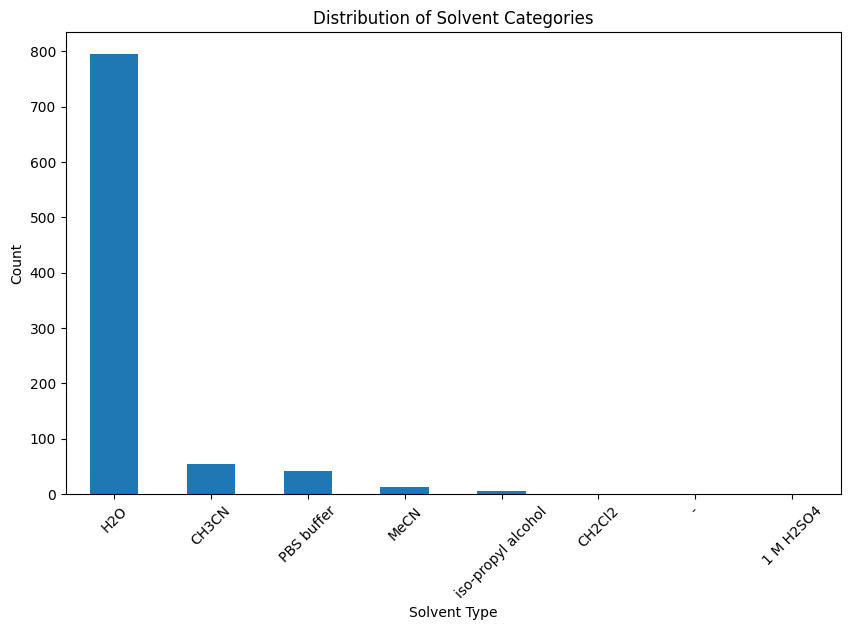

In [31]:
import matplotlib.pyplot as plt

# Count occurrences of each unique solvent
solvent_counts = combined_df['solvent'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
solvent_counts.plot(kind='bar')
plt.xlabel("Solvent Type")
plt.ylabel("Count")
plt.title("Distribution of Solvent Categories")
plt.xticks(rotation=45)
plt.show()


In [32]:
combined_df[combined_df['solvent'] == '-']

,SMILE,solvent,type,ph,SRP
890,[CH-]1[CH-][CH-][CH-][CH-]1.[CH-]1C=CC=C1.[Fe],-,neutral,7.0,0.75


In [33]:
combined_df['ph']

0      7.0
1      7.0
2      7.0
3      7.0
4      7.0
      ... 
907    7.0
908    7.0
909    7.0
910    7.0
911    7.0
Name: ph, Length: 912, dtype: float64

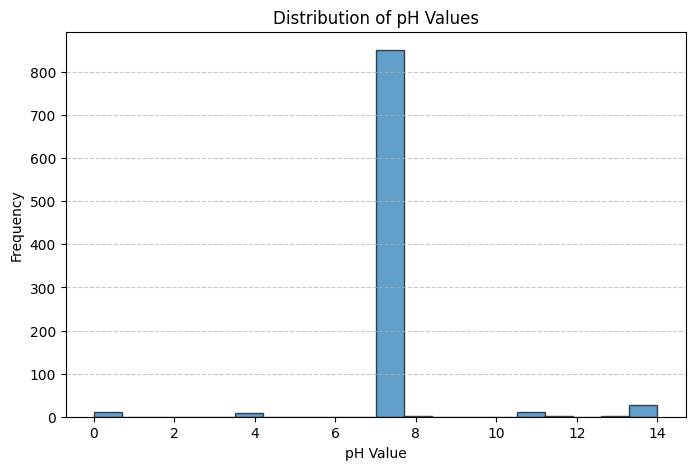

In [34]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.hist(combined_df['ph'].dropna(), bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('pH Value')
plt.ylabel('Frequency')
plt.title('Distribution of pH Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator


# Define a function to compute Morgan fingerprints
def compute_morgan_fp(smiles, radius=2, n_bits=1024):
    generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(generator.GetFingerprint(mol))
    else:
        return [0] * n_bits  # Return zero vector if molecule creation fails
    

def smiles_to_vector(smiles, tokenizer, model):
    """SMILES 문자열을 벡터로 변환."""
    # SMILES 토큰화
    tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # MolBERT를 통해 임베딩 생성
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # 각 SMILES의 평균 임베딩 반환
    return embeddings.squeeze(0).numpy()  # 1D 벡터 반환

In [36]:
def check_morgan_fp(smiles_list):
    error_smiles = []
    generator = GetMorganGenerator(radius=2, fpSize=1024)
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                raise ValueError(f"Invalid molecule for SMILES: {smiles}")
        except Exception as e:
            error_smiles.append(smiles)
    return error_smiles

# Collect SMILES with errors
error_smiles_c = check_morgan_fp(combined_df['SMILE'])
combined_df_morgan = combined_df[~combined_df['SMILE'].isin(error_smiles_c)]
error_smiles_1 = check_morgan_fp(sheet1_df['SMILE'])
sheet1_df_morgan = sheet1_df[~sheet1_df['SMILE'].isin(error_smiles_1)]
error_smiles_2 = check_morgan_fp(sheet2_df['SMILE'])
sheet2_df_morgan = sheet2_df[~sheet2_df['SMILE'].isin(error_smiles_2)]
error_smiles_o = check_morgan_fp(original_df['SMILE'])
original_df_morgan = original_df[~original_df['SMILE'].isin(error_smiles_o)]

[11:27:08] SMILES Parse Error: syntax error while parsing: C[N+](C)(C)CC1=C[C-](C=C1)[Fe+2][C-]2C=CC=C2.[X-]
[11:27:08] SMILES Parse Error: Failed parsing SMILES 'C[N+](C)(C)CC1=C[C-](C=C1)[Fe+2][C-]2C=CC=C2.[X-]' for input: 'C[N+](C)(C)CC1=C[C-](C=C1)[Fe+2][C-]2C=CC=C2.[X-]'
[11:27:08] Explicit valence for atom # 1 B, 4, is greater than permitted
[11:27:08] SMILES Parse Error: extra open parentheses for input: 'CC(C)N(CC[N]1C=CN=C1([N+]([O-])=O)C(C)C'
[11:27:08] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)CN(CC(O)C[N]1C=CN=C1([N+]([O-])=O)C(C)(C)C'
[11:27:08] Explicit valence for atom # 5 N, 4, is greater than permitted
[11:27:08] SMILES Parse Error: extra open parentheses for input: 'C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H]'
[11:27:08] SMILES Parse Error: extra open parentheses for input: 'C1=NC2=C(N1[C@H]3[C@@H]([C@@H]([C@H]'
[11:27:08] Explicit valence for atom # 20 N, 4, is greater than permitted
[11:27:08] SMILES Parse Error: syntax error while parsing: 

In [37]:
combined_df_morgan

,SMILE,solvent,type,ph,SRP
0,O=C(O)C1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.5190
1,O=C(O)CC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3640
2,C1=CC=C[C-]1[Fe+2][C-]1C(C=CC(=O)O)=CC=C1,PBS buffer,neutral,7.0,0.4640
3,O=C(O)CCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3340
4,O=C(O)CCCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3240
...,...,...,...,...,...
907,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.2100
908,[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Ru+2],H2O,neutral,7.0,0.8600
909,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.1400
910,[O-][Ru](=O)(=O)[O-],H2O,neutral,7.0,0.5900


In [43]:
import optuna
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


def optimize_model(trial, model_name, X_train, y_train):
    """Optimize hyperparameters for different models using Optuna and return RMSE."""
    if model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
        }
        model = XGBRegressor(objective="reg:squarederror", **params, random_state=42)

    elif model_name == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
        }
        model = RandomForestRegressor(**params, random_state=42)

    elif model_name == "GradientBoosting":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
        }
        model = GradientBoostingRegressor(**params, random_state=42)

    elif model_name == "SVR":
        params = {
            "C": trial.suggest_float("C", 0.1, 100),
            "gamma": trial.suggest_float("gamma", 0.001, 1),
            "epsilon": trial.suggest_float("epsilon", 0.01, 0.2),
        }
        model = SVR(**params)

    elif model_name == "Ridge":
        params = {"alpha": trial.suggest_float("alpha", 0.01, 10)}
        model = Ridge(**params)

    else:
        raise ValueError("Unsupported model.")

    # 교차 검증을 통한 RMSE 평가
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")
    return -np.mean(scores)  # RMSE는 음수 값이므로 양수로 변환


In [48]:
def process_and_evaluate_with_ensemble(df, name, embedding_method="morgan", tokenizer=None, model=None):
    """Preprocess data, apply embedding, optimize models with Optuna, perform ensemble learning, and evaluate."""
    
    # Embedding generation
    if embedding_method == "morgan":
        df["vector"] = df["SMILE"].apply(compute_morgan_fp)
    elif embedding_method == "chemberta":
        if tokenizer is None or model is None:
            raise ValueError("chemberta requires a tokenizer and model.")
        df["vector"] = df["SMILE"].apply(lambda x: smiles_to_vector(x, tokenizer, model))
    else:
        raise ValueError("Invalid embedding_method. Choose 'morgan' or 'chemberta'.")

    # Convert vectors to matrix
    vector_df = pd.DataFrame(df["vector"].tolist(), index=df.index)
    X = pd.concat([vector_df, df[['solvent', 'type', 'ph']]], axis=1)
    y = df['SRP']

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # One-hot encode 'type' and 'solvent', scale numerical features like 'pH'
    column_transformer = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['type', 'solvent']),
        ('scale', StandardScaler(), ['ph'])
    ], remainder='passthrough')

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Transform data
    X_train_transformed = column_transformer.fit_transform(X_train)
    X_test_transformed = column_transformer.transform(X_test)

    # Define models for optimization
    model_names = ["RandomForest", "GradientBoosting", "XGBoost", "SVR", "Ridge"]
    best_params_dict = {}  # 각 모델의 best_params 저장
    models = {}

    # Apply Optuna optimization for each model
    for model_name in model_names:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: optimize_model(trial, model_name, X_train_transformed, y_train), n_trials=20)
        best_params_dict[model_name] = study.best_params  

        # 최적화된 모델 생성
        if model_name == "XGBoost":
            models[model_name] = XGBRegressor(objective="reg:squarederror", **best_params_dict[model_name], random_state=42)
        elif model_name == "RandomForest":
            models[model_name] = RandomForestRegressor(**best_params_dict[model_name], random_state=42)
        elif model_name == "GradientBoosting":
            models[model_name] = GradientBoostingRegressor(**best_params_dict[model_name], random_state=42)
        elif model_name == "SVR":
            models[model_name] = SVR(**best_params_dict[model_name])
        elif model_name == "Ridge":
            models[model_name] = Ridge(**best_params_dict[model_name])

    # Train and evaluate individual models
    results = {}
    trained_models = []
    
    for model_name, ml_model in models.items():
        ml_model.fit(X_train_transformed, y_train)
        trained_models.append((model_name, ml_model))  # Store trained models for ensemble

        # Predict and evaluate
        y_pred = ml_model.predict(X_test_transformed)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)  # RMSE 추가
        
        results[model_name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
        print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")
        print(f"Best Parameters: {best_params_dict[model_name]}\n")

    # **1. Voting Regressor (Soft Voting)**
    voting_regressor = VotingRegressor(estimators=trained_models)
    voting_regressor.fit(X_train_transformed, y_train)
    y_pred_voting = voting_regressor.predict(X_test_transformed)
    
    results["Voting Regressor"] = {'MSE': mean_squared_error(y_test, y_pred_voting),
                                   'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_voting)),
                                   'R2': r2_score(y_test, y_pred_voting)}

    # **2. Stacking Regressor (Meta-model: Ridge Regression)**
    stacking_regressor = StackingRegressor(estimators=trained_models, final_estimator=Ridge(alpha=1.0))
    stacking_regressor.fit(X_train_transformed, y_train)
    y_pred_stacking = stacking_regressor.predict(X_test_transformed)

    results["Stacking Regressor"] = {'MSE': mean_squared_error(y_test, y_pred_stacking),
                                     'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_stacking)),
                                     'R2': r2_score(y_test, y_pred_stacking)}

    return pd.DataFrame(results).T

In [49]:
# Apply the function to all datasets with Morgan Fingerprints
results_combined_morgan = process_and_evaluate_with_ensemble(combined_df_morgan, "Combined", embedding_method="morgan")
# results_sheet1_morgan = process_and_evaluate_with_embedding(sheet1_df_morgan, "Sheet1", embedding_method="morgan")
# results_sheet2_morgan = process_and_evaluate_with_embedding(sheet2_df_morgan, "Sheet2", embedding_method="morgan")
# results_original_morgan = process_and_evaluate_with_embedding(original_df_morgan, "Original", embedding_method="morgan")

# Apply the function to all datasets with MolBERT
results_combined_molbert = process_and_evaluate_with_ensemble(combined_df, "Combined", embedding_method="chemberta", tokenizer=tokenizer, model=model)
# results_sheet1_molbert = process_and_evaluate_with_embedding(sheet1_df, "Sheet1", embedding_method="chemberta", tokenizer=tokenizer, model=model)
# results_sheet2_molbert = process_and_evaluate_with_embedding(sheet2_df, "Sheet2", embedding_method="chemberta", tokenizer=tokenizer, model=model)
# results_original_molbert = process_and_evaluate_with_embedding(original_df, "Original", embedding_method="chemberta", tokenizer=tokenizer, model=model)



/tmp/ipykernel_2046277/1360704467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vector"] = df["SMILE"].apply(compute_morgan_fp)
[I 2025-03-09 14:50:39,081] A new study created in memory with name: no-name-8aa29d41-c748-4b03-911b-958e55031a47
[I 2025-03-09 14:50:43,515] Trial 0 finished with value: 0.3375806180468411 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 0 with value: 0.3375806180468411.
[I 2025-03-09 14:51:11,767] Trial 1 finished with value: 0.3188338527420287 and parameters: {'n_estimators': 1000, 'max_depth': 17}. Best is trial 1 with value: 0.3188338527420287.
[I 2025-03-09 14:51:37,270] Trial 2 finished with value: 0.31907649221101536 and parameters: {'n_estimators': 900, 'max_depth': 17}. Best is tri

RandomForest - RMSE: 0.2502, R²: 0.7649
Best Parameters: {'n_estimators': 500, 'max_depth': 18}

GradientBoosting - RMSE: 0.2514, R²: 0.7626
Best Parameters: {'n_estimators': 100, 'learning_rate': 0.16967584855058376, 'max_depth': 7}

XGBoost - RMSE: 0.2735, R²: 0.7190
Best Parameters: {'n_estimators': 1900, 'learning_rate': 0.28821587022851153, 'max_depth': 10}

SVR - RMSE: 0.2804, R²: 0.7047
Best Parameters: {'C': 79.50787736404433, 'gamma': 0.013815634002471926, 'epsilon': 0.07793182375319604}

Ridge - RMSE: 0.2920, R²: 0.6798
Best Parameters: {'alpha': 8.277149037312132}



[I 2025-03-09 15:01:38,564] A new study created in memory with name: no-name-fa22f5cf-a8dc-45f1-b942-27ac991a74d5
[I 2025-03-09 15:02:31,496] Trial 0 finished with value: 0.4038551369839021 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 0 with value: 0.4038551369839021.
[I 2025-03-09 15:06:05,201] Trial 1 finished with value: 0.4004605955000398 and parameters: {'n_estimators': 700, 'max_depth': 17}. Best is trial 1 with value: 0.4004605955000398.
[I 2025-03-09 15:09:12,536] Trial 2 finished with value: 0.4024784445529143 and parameters: {'n_estimators': 800, 'max_depth': 9}. Best is trial 1 with value: 0.4004605955000398.
[I 2025-03-09 15:11:38,494] Trial 3 finished with value: 0.41591239295544863 and parameters: {'n_estimators': 1000, 'max_depth': 5}. Best is trial 1 with value: 0.4004605955000398.
[I 2025-03-09 15:13:40,707] Trial 4 finished with value: 0.4013914216127219 and parameters: {'n_estimators': 400, 'max_depth': 20}. Best is trial 1 with value: 0.4004

RandomForest - RMSE: 0.2981, R²: 0.6319
Best Parameters: {'n_estimators': 600, 'max_depth': 13}

GradientBoosting - RMSE: 0.2846, R²: 0.6646
Best Parameters: {'n_estimators': 700, 'learning_rate': 0.05290136176518097, 'max_depth': 3}

XGBoost - RMSE: 0.2829, R²: 0.6685
Best Parameters: {'n_estimators': 1400, 'learning_rate': 0.11423822283539131, 'max_depth': 3}

SVR - RMSE: 0.2805, R²: 0.6743
Best Parameters: {'C': 65.47023961272025, 'gamma': 0.09437492001127988, 'epsilon': 0.03913948533341162}

Ridge - RMSE: 0.3094, R²: 0.6035
Best Parameters: {'alpha': 2.163973629547617}



In [50]:
print(results_combined_morgan)

                         MSE      RMSE        R2
RandomForest        0.062619  0.250238  0.764853
GradientBoosting    0.063214  0.251423  0.762620
XGBoost             0.074829  0.273549  0.719003
SVR                 0.078630  0.280410  0.704729
Ridge               0.085255  0.291985  0.679850
Voting Regressor    0.059276  0.243467  0.777407
Stacking Regressor  0.058460  0.241785  0.780471


In [61]:
%pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [62]:
# Re-import necessary libraries after execution state reset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# R2 Score 그래프
sns.barplot(x="Model", y="R2", data=results_combined_morgan, palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Model Performance (R² Score)")
plt.xlabel("Model")
plt.ylabel("R² Score")

# 그래프 표시
plt.show()


ValueError: Could not interpret value `Model` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [51]:
print(results_combined_molbert)

                         MSE      RMSE        R2
RandomForest        0.088876  0.298121  0.631941
GradientBoosting    0.080984  0.284577  0.664626
XGBoost             0.080058  0.282945  0.668459
SVR                 0.078653  0.280452  0.674278
Ridge               0.095733  0.309408  0.603544
Voting Regressor    0.070200  0.264953  0.709285
Stacking Regressor  0.069235  0.263125  0.713281


In [102]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [52]:
import matplotlib.pyplot as plt

# 데이터 재구조화
pivot_r2 = results_combined_morgan.reset_index().pivot(index="Dataset", columns="index", values="R2")
pivot_mse = results_combined_morgan.reset_index().pivot(index="Dataset", columns="index", values="RMSE")

# 그래프 그리기
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# R² 그래프
pivot_r2.plot(kind='bar', ax=axes[0], cmap='viridis', edgecolor='black')
axes[0].set_title("R² Scores Across Models and Datasets", fontsize=14)
axes[0].set_xlabel("Dataset", fontsize=12)
axes[0].set_ylabel("R² Score", fontsize=12)
axes[0].legend(title="Model", fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# MSE 그래프
pivot_mse.plot(kind='bar', ax=axes[1], cmap='plasma', edgecolor='black')
axes[1].set_title("MSE Scores Across Models and Datasets", fontsize=14)
axes[1].set_xlabel("Dataset", fontsize=12)
axes[1].set_ylabel("MSE", fontsize=12)
axes[1].legend(title="Model", fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()


KeyError: 'Dataset'

In [104]:
print("\ChemBerta Results:")
print(final_results_molbert)

\ChemBerta Results:
                        MSE        R2   Dataset
Random Forest      0.088501  0.633494  Combined
Gradient Boosting  0.080197  0.667884  Combined
LightGBM           0.099461  0.588106  Combined
XGBoost            0.088988  0.631478  Combined
Random Forest      0.169332  0.603992    Sheet1
Gradient Boosting  0.140848  0.670608    Sheet1
LightGBM           0.165942  0.611921    Sheet1
XGBoost            0.156597  0.633777    Sheet1
Random Forest      0.107056  0.558799    Sheet2
Gradient Boosting  0.100919  0.584088    Sheet2
LightGBM           0.119238  0.508592    Sheet2
XGBoost            0.121725  0.498342    Sheet2
Random Forest      0.082034  0.619449  Original
Gradient Boosting  0.064748  0.699639  Original
LightGBM           0.085103  0.605214  Original
XGBoost            0.067147  0.688510  Original


<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipykernel_2170526/2559673444.py:1: SyntaxWarning: invalid escape sequence '\C'
  print("\ChemBerta Results:")


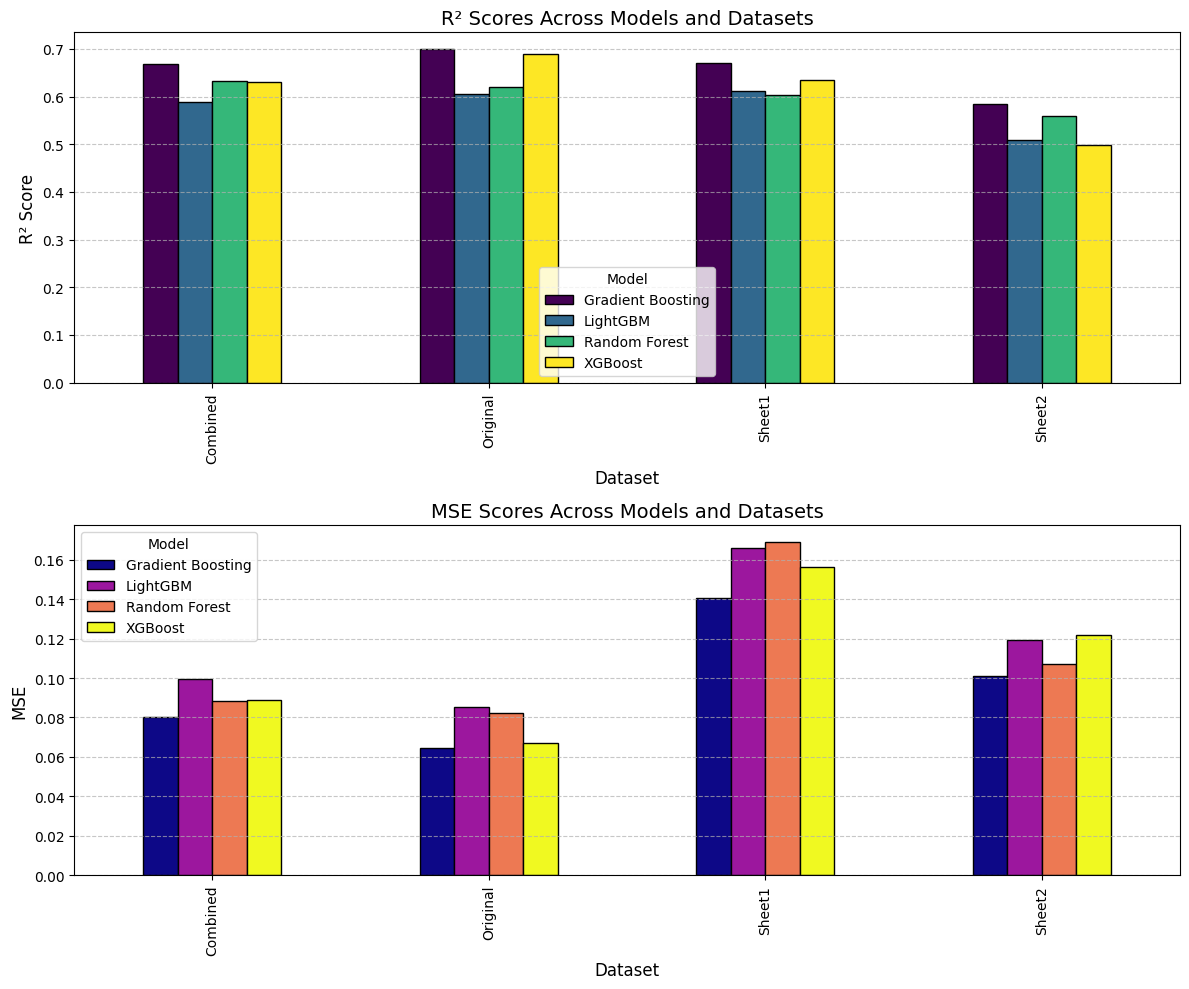

In [105]:
import matplotlib.pyplot as plt

# 데이터 재구조화
pivot_r2 = final_results_molbert.reset_index().pivot(index="Dataset", columns="index", values="R2")
pivot_mse = final_results_molbert.reset_index().pivot(index="Dataset", columns="index", values="MSE")

# 그래프 그리기
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# R² 그래프
pivot_r2.plot(kind='bar', ax=axes[0], cmap='viridis', edgecolor='black')
axes[0].set_title("R² Scores Across Models and Datasets", fontsize=14)
axes[0].set_xlabel("Dataset", fontsize=12)
axes[0].set_ylabel("R² Score", fontsize=12)
axes[0].legend(title="Model", fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# MSE 그래프
pivot_mse.plot(kind='bar', ax=axes[1], cmap='plasma', edgecolor='black')
axes[1].set_title("MSE Scores Across Models and Datasets", fontsize=14)
axes[1].set_xlabel("Dataset", fontsize=12)
axes[1].set_ylabel("MSE", fontsize=12)
axes[1].legend(title="Model", fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()


In [106]:
combined_df

,SMILE,solvent,type,ph,SRP,vector
0,O=C(O)C1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.5190,"[-0.14294513, 0.32871792, -0.053337175, -0.111..."
1,O=C(O)CC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3640,"[-0.1361956, 0.3553084, -0.05780188, -0.143673..."
2,C1=CC=C[C-]1[Fe+2][C-]1C(C=CC(=O)O)=CC=C1,PBS buffer,neutral,7.0,0.4640,"[-0.06560041, 0.40443665, -0.043676615, -0.096..."
3,O=C(O)CCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3340,"[-0.14883226, 0.38712597, -0.055336274, -0.145..."
4,O=C(O)CCCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3240,"[-0.15677902, 0.39083976, -0.05654359, -0.1771..."
...,...,...,...,...,...,...
907,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.2100,"[0.20522906, 1.3178723, -0.26771122, 1.329995,..."
908,[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Ru+2],H2O,neutral,7.0,0.8600,"[0.21523434, 0.22400753, -0.006676303, 0.12204..."
909,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.1400,"[0.20522906, 1.3178723, -0.26771122, 1.329995,..."
910,[O-][Ru](=O)(=O)[O-],H2O,neutral,7.0,0.5900,"[-0.19430445, 2.4751732, -0.22807251, 1.217024..."


In [107]:
!pip install torch_geometric

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
len(combined_df_morgan['vector'][0])

1024

In [58]:
combined_df_morgan

,SMILE,solvent,type,ph,SRP,vector
0,O=C(O)C1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.5190,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C(O)CC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3640,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C1=CC=C[C-]1[Fe+2][C-]1C(C=CC(=O)O)=CC=C1,PBS buffer,neutral,7.0,0.4640,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O=C(O)CCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3340,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C(O)CCCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3240,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
907,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.2100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
908,[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Ru+2],H2O,neutral,7.0,0.8600,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
909,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.1400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
910,[O-][Ru](=O)(=O)[O-],H2O,neutral,7.0,0.5900,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [53]:
combined_df

,SMILE,solvent,type,ph,SRP,vector
0,O=C(O)C1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.5190,"[-0.14294513, 0.32871792, -0.053337175, -0.111..."
1,O=C(O)CC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3640,"[-0.1361956, 0.3553084, -0.05780188, -0.143673..."
2,C1=CC=C[C-]1[Fe+2][C-]1C(C=CC(=O)O)=CC=C1,PBS buffer,neutral,7.0,0.4640,"[-0.06560041, 0.40443665, -0.043676615, -0.096..."
3,O=C(O)CCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3340,"[-0.14883226, 0.38712597, -0.055336274, -0.145..."
4,O=C(O)CCCC1=CC=C[C-]1[Fe+2][C-]1C=CC=C1,PBS buffer,neutral,7.0,0.3240,"[-0.15677902, 0.39083976, -0.05654359, -0.1771..."
...,...,...,...,...,...,...
907,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.2100,"[0.20522906, 1.3178723, -0.26771122, 1.329995,..."
908,[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Ru+2],H2O,neutral,7.0,0.8600,"[0.21523434, 0.22400753, -0.006676303, 0.12204..."
909,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,7.0,0.1400,"[0.20522906, 1.3178723, -0.26771122, 1.329995,..."
910,[O-][Ru](=O)(=O)[O-],H2O,neutral,7.0,0.5900,"[-0.19430445, 2.4751732, -0.22807251, 1.217024..."


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# 신경망 모델 정의
class AdvancedSRPNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedSRPNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),  # 1st hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),  # 2nd hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),  # 3rd hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 64),  # 4th hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 1)  # Output layer
        )
    
    def forward(self, x):
        return self.fc(x)


# Convert vectors to matrix
vector_df = pd.DataFrame(combined_df["vector"].tolist(), index=combined_df.index)  # Morgan/MolBERT 벡터
X = pd.concat([vector_df, combined_df[['solvent', 'type', 'ph']]], axis=1)
y = combined_df['SRP']  # Target 값

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# One-hot encode 'type' and 'solvent' and include numerical features like 'pH'
column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['type', 'solvent']),
    ('numeric', 'passthrough', ['ph'])  # Assuming 'ph' is a column in the DataFrame
], remainder='passthrough')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform data
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
    
# 데이터 전처리 (Standard Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# 텐서 변환
# 텐서 변환 (numpy로 변환 후 처리)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)  # numpy로 변환
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)  # numpy로 변환


# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_model = AdvancedSRPNet(input_dim=X_train_tensor.shape[1]).to(device)
optimizer = optim.Adam(neural_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 루프
epochs = 200
for epoch in range(epochs):
    neural_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = neural_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# 평가
neural_model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    y_pred = neural_model(X_test_tensor).view(-1).cpu().numpy()
    y_true = y_test_tensor.view(-1).cpu().numpy()

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Epoch 1/200, Loss: 10.1834
Epoch 2/200, Loss: 6.2548
Epoch 3/200, Loss: 5.5110
Epoch 4/200, Loss: 5.5670
Epoch 5/200, Loss: 4.1783
Epoch 6/200, Loss: 4.1857
Epoch 7/200, Loss: 3.6756
Epoch 8/200, Loss: 3.4625
Epoch 9/200, Loss: 3.3922
Epoch 10/200, Loss: 2.7629
Epoch 11/200, Loss: 2.7001
Epoch 12/200, Loss: 2.7392
Epoch 13/200, Loss: 2.4221
Epoch 14/200, Loss: 2.2236
Epoch 15/200, Loss: 2.4792
Epoch 16/200, Loss: 2.3456
Epoch 17/200, Loss: 2.1837
Epoch 18/200, Loss: 2.2159
Epoch 19/200, Loss: 1.8132
Epoch 20/200, Loss: 1.7888
Epoch 21/200, Loss: 1.8725
Epoch 22/200, Loss: 1.7392
Epoch 23/200, Loss: 1.8132
Epoch 24/200, Loss: 1.8694
Epoch 25/200, Loss: 1.7967
Epoch 26/200, Loss: 1.8599
Epoch 27/200, Loss: 1.7204
Epoch 28/200, Loss: 1.5394
Epoch 29/200, Loss: 1.8118
Epoch 30/200, Loss: 1.3827
Epoch 31/200, Loss: 1.6291
Epoch 32/200, Loss: 1.8947
Epoch 33/200, Loss: 1.6515
Epoch 34/200, Loss: 1.7181
Epoch 35/200, Loss: 1.8044
Epoch 36/200, Loss: 1.5570
Epoch 37/200, Loss: 1.7106
Epoch 38/

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator


# **Morgan Fingerprints 생성 함수**
def compute_morgan_fp(smiles, radius=2, n_bits=1024):
    generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(generator.GetFingerprint(mol))
    else:
        return [0] * n_bits  # SMILES 변환 실패 시 0으로 채운 벡터 반환


# **신경망 모델 정의**
class AdvancedSRPNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedSRPNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),  # 1st hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),  # 2nd hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),  # 3rd hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 64),  # 4th hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 1)  # Output layer
        )
    
    def forward(self, x):
        return self.fc(x)


# **Morgan Fingerprints 벡터 생성**
# combined_df["vector"] = combined_df["SMILE"].apply(compute_morgan_fp)

# **벡터를 데이터프레임으로 변환**
vector_df = pd.DataFrame(combined_df_morgan["vector"].tolist(), index=combined_df_morgan.index)
X = pd.concat([vector_df, combined_df_morgan[['solvent', 'type', 'ph']]], axis=1)
y = combined_df_morgan['SRP']

# **컬럼 변환 (One-Hot Encoding)**
column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['type', 'solvent']),
    ('numeric', 'passthrough', ['ph'])  # pH는 그대로 유지
], remainder='passthrough')

# **Train-Test Split**
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **데이터 변환 적용**
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# **데이터 스케일링**
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# **Tensor 변환**
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

# **DataLoader 생성**
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# **모델 초기화**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_model = AdvancedSRPNet(input_dim=X_train_tensor.shape[1]).to(device)
optimizer = optim.Adam(neural_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# **Learning rate scheduler**
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# **학습 루프**
epochs = 200
for epoch in range(epochs):
    neural_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = neural_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# **평가**
neural_model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    y_pred = neural_model(X_test_tensor).view(-1).cpu().numpy()
    y_true = y_test_tensor.view(-1).cpu().numpy()

# **성능 평가**
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Epoch 1/200, Loss: 10.8305
Epoch 2/200, Loss: 5.8226
Epoch 3/200, Loss: 4.1623
Epoch 4/200, Loss: 3.6831
Epoch 5/200, Loss: 2.9512
Epoch 6/200, Loss: 2.7206
Epoch 7/200, Loss: 2.1592
Epoch 8/200, Loss: 2.0552
Epoch 9/200, Loss: 1.8926
Epoch 10/200, Loss: 1.8544
Epoch 11/200, Loss: 1.7819
Epoch 12/200, Loss: 1.6961
Epoch 13/200, Loss: 1.4412
Epoch 14/200, Loss: 1.4088
Epoch 15/200, Loss: 1.3933
Epoch 16/200, Loss: 1.2470
Epoch 17/200, Loss: 1.1504
Epoch 18/200, Loss: 1.3759
Epoch 19/200, Loss: 1.2284
Epoch 20/200, Loss: 1.3848
Epoch 21/200, Loss: 1.0688
Epoch 22/200, Loss: 1.1410
Epoch 23/200, Loss: 1.3973
Epoch 24/200, Loss: 1.1094
Epoch 25/200, Loss: 1.2945
Epoch 26/200, Loss: 1.1830
Epoch 27/200, Loss: 1.3521
Epoch 28/200, Loss: 1.2158
Epoch 29/200, Loss: 1.0300
Epoch 30/200, Loss: 1.1150
Epoch 31/200, Loss: 0.8080
Epoch 32/200, Loss: 1.0338
Epoch 33/200, Loss: 1.0768
Epoch 34/200, Loss: 1.0896
Epoch 35/200, Loss: 0.9877
Epoch 36/200, Loss: 0.9313
Epoch 37/200, Loss: 1.0355
Epoch 38/

### SMILES -> MolBERT / solvent, type -> one hot encoder

In [ ]:
combined_df

,IUPAC Name,SMILE,solvent,type,SRP,smiles_vector,solvent_vector,combined_vector
0,NaN,C1=CC(=CC=C1[CH2])OC2=CC=CC=C2,CH3CN,radical,0.6900,"[0.37235165, 0.4548144, -0.1370826, -0.2576731...","[0.018207889, -0.004579143, -0.17621377, -0.15...","[0.37235165, 0.4548144, -0.1370826, -0.2576731..."
1,NaN,C2(=CC=C(C=C2)C)[CH2],CH3CN,radical,0.7500,"[0.96468383, 0.07780989, 0.06764517, -0.914620...","[0.018207889, -0.004579143, -0.17621377, -0.15...","[0.96468383, 0.07780989, 0.06764517, -0.914620..."
2,NaN,C1=C(C=CC=C1[CH2])C,CH3CN,radical,0.9100,"[-0.01689385, 0.059199937, 0.17726411, -0.6303...","[0.018207889, -0.004579143, -0.17621377, -0.15...","[-0.01689385, 0.059199937, 0.17726411, -0.6303..."
3,NaN,C1=CC(=CC=C1[CH2])Cl,CH3CN,radical,0.9700,"[0.4734047, 0.09528664, 0.053799897, -0.385046...","[0.018207889, -0.004579143, -0.17621377, -0.15...","[0.4734047, 0.09528664, 0.053799897, -0.385046..."
4,NaN,C1(=CC=C(C=C1)[CH2])COC,CH3CN,radical,1.0400,"[0.5430897, 0.05833339, 0.020223655, -0.721207...","[0.018207889, -0.004579143, -0.17621377, -0.15...","[0.5430897, 0.05833339, 0.020223655, -0.721207..."
...,...,...,...,...,...,...,...,...
634,"1,10-phenanthroline;ruthenium(2+)",C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,0.2100,"[0.41575703, 0.2542927, -0.5646848, -0.4510101...","[0.012555743, 0.23722024, -1.1103475, 0.377038...","[0.41575703, 0.2542927, -0.5646848, -0.4510101..."
635,ruthenium(2+);hexacyanide,[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Ru+2],H2O,neutral,0.8600,"[0.46838722, 0.2479201, -0.5273087, 0.3407453,...","[0.012555743, 0.23722024, -1.1103475, 0.377038...","[0.46838722, 0.2479201, -0.5273087, 0.3407453,..."
636,"vanadium(2+);1,10-Phenanthroline",C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(...,H2O,neutral,0.1400,"[0.42937854, 0.24661127, -0.55939454, -0.44670...","[0.012555743, 0.23722024, -1.1103475, 0.377038...","[0.42937854, 0.24661127, -0.55939454, -0.44670..."
637,dioxido(dioxo)ruthenium,[O-][Ru](=O)(=O)[O-],H2O,neutral,0.5900,"[-0.19474776, 0.1279889, -0.6064397, -0.332728...","[0.012555743, 0.23722024, -1.1103475, 0.377038...","[-0.19474776, 0.1279889, -0.6064397, -0.332728..."


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'combined.csv'
data = pd.read_csv(file_path)

# Split into train, validation, and test sets
train, temp = train_test_split(data, test_size=0.3, random_state=42)  # 70% train
valid, test = train_test_split(temp, test_size=0.5, random_state=42)  # 15% valid, 15% test

# Save to separate files
train.to_csv('train.csv', index=False)
valid.to_csv('valid.csv', index=False)
test.to_csv('test.csv', index=False)

# Provide confirmation
import os
os.listdir()


['train_filtered.csv',
 'combined.csv',
 'Reduction potential - reaction.csv',
 'duplicate_rows_product.csv',
 'data_view.ipynb',
 'mol_viz.ipynb',
 'valid_filtered.csv',
 'test.csv',
 'Reduction potential - product_only.csv',
 'duplicate_rows_reaction.csv',
 '.ipynb_checkpoints',
 'mol_viz.zip',
 'Reduction potential - radical.csv',
 'product_modified.csv',
 'mol2.ipynb',
 'test_filtered.csv',
 'ml.ipynb',
 'train.csv',
 'valid.csv',
 'radical_modified.csv',
 'ring_data3_calculated.csv',
 'reaction_modified.csv']

In [62]:
# Filter only 'SMILES' and 'SRP' columns
train_filtered = train[['SMILE', 'SRP']]
valid_filtered = valid[['SMILE', 'SRP']]
test_filtered = test[['SMILE', 'SRP']]

# Save filtered data to new CSV files
train_filtered.to_csv('train_filtered.csv', index=False)
valid_filtered.to_csv('valid_filtered.csv', index=False)
test_filtered.to_csv('test_filtered.csv', index=False)

# Confirm saved files
import os
os.listdir()


['train_filtered.csv',
 'combined.csv',
 'Reduction potential - reaction.csv',
 'duplicate_rows_product.csv',
 'data_view.ipynb',
 'mol_viz.ipynb',
 'valid_filtered.csv',
 'test.csv',
 'Reduction potential - product_only.csv',
 'duplicate_rows_reaction.csv',
 '.ipynb_checkpoints',
 'mol_viz.zip',
 'Reduction potential - radical.csv',
 'product_modified.csv',
 'mol2.ipynb',
 'test_filtered.csv',
 'ml.ipynb',
 'train.csv',
 'valid.csv',
 'radical_modified.csv',
 'ring_data3_calculated.csv',
 'reaction_modified.csv']